# Shogi Engine Decision Visualization（HDSフレーム・完全版デモ）

このノートブックは、将棋エンジンの「黒箱（ブラックボックス）」的な着手選択を  
**HDSフレーム（Objective → Axes → Alternatives → Risk(EVR) → Choice）** で分解して可視化するデモです。

---

## このノートブックでやっていること

1. **入力（サンプル局面）**
   - 1局面ぶんの SFEN
   - エンジン評価値つき候補手（3手）  
   ※実際には他エンジンの出力ログからコピペで差し替え可能。

2. **HDSによる分解**
   - 目的（Objective）
   - 評価軸（Axes）
   - 候補手の比較（Alternatives）
   - リスクと評価値レンジ（Risk / EVR）
   - 最終選択（Choice）

3. **出力**
   - 候補手テーブル  
     - `eval`：評価値  
     - `eval_ratio`：最善手比パーセンテージ  
     - `gap_to_best`：最善手との差（cp）  
     - `risk_category`：リスクカテゴリ  
     - `eval_comment`：日本語コメント（大中小のニュアンス）
   - 機械的な HDS レイヤーログ（5層構造）
   - 日本語の EXECUTIVE SUMMARY（上位手の比較解説）
   - 盤面＋評価バーの可視化

4. **決定性チェック**
   - 同じ入力で 3 回実行し、ログとサマリーが完全一致するかを検証  
   - 「同じ局面を何度回しても同じ説明が返る」ことを保証する。

---

## 使い方（カスタマイズ方法）

- 別局面を説明したい場合は、コード側の `sample_position` 内の
  - `position_id`
  - `sfen`
  - `candidate_moves`（`move`, `eval`, `desc` など）
- この部分だけを書き換えれば、同じ形式で説明が自動生成されます。

---

## 想定するユースケース

- 将棋AIの「なぜこの一手を選んだのか？」を人間向けに説明したいとき
- 研究者・ビジネスサイド・エンジニアに対して  
  「ブラックボックスをどのレベルまで分解して可視化できるか」のデモを見せるとき
- Kaggle / 社内勉強会 / 外部プレゼン用の最低限動く再現性付きサンプルとして

以下の Code セルは、外部APIなし・オフライン・決定的に動作するよう設計されています。


--- [Data] Candidate Metrics ---


,move,eval,eval_ratio,gap_to_best,risk_category,eval_comment
0,7g7f,300,1.000000,0,low_risk_stable,候補手の中で最善手です。評価値は基準の100%として扱われます。
1,2g2f,250,0.833333,50,low_risk_stable,最善手との差は50点（約83.3%水準）で、ほぼ同等の安定した選択肢です。
2,3g3f,120,0.400000,180,balanced,最善手との差は180点（約40.0%水準）で、十分実戦的ですがやや見劣りします。



=== HDS DECISION LAYER LOG ===
Engine: DemiGlace-Zero | ID: fujii_magic_01
------------------------------
[LAYER 1: OBJECTIVE]
>> 勝率（評価値）の最大化。現在の最大評価値: 300 点
>> 副次目的: 一定の安全性を保ちつつ、相手に難しい局面を押し付ける。

[LAYER 2: EVALUATION AXES]
* 駒得・駒の働き（Material / Mobility）
* 玉の安全度（King Safety）
* 主導権・制空権（Initiative / Space）

[LAYER 3: ALTERNATIVES ANALYSIS]
>> 手 7g7f: 評価値 300 点（正規化 1.00）
   解説: 中央の歩を突き出しつつ、玉型の安全性も維持する一手です。
>> 手 2g2f: 評価値 250 点（正規化 0.72）
   解説: 飛車先の攻めを加速しますが、やや玉型の安定性を犠牲にします。
>> 手 3g3f: 評価値 120 点（正規化 0.00）
   解説: 角道を通しつつ駒組みを進めますが、全体のバランスはやや劣ります。

[LAYER 4: RISK (EVR) ASSESSMENT]
>> 7g7f: 最善手との差 0 点 -> カテゴリ: LOW_RISK_STABLE
>> 2g2f: 最善手との差 50 点 -> カテゴリ: LOW_RISK_STABLE
>> 3g3f: 最善手との差 180 点 -> カテゴリ: BALANCED
>> 局面全体: 各候補手の評価が接近しており、安定した状態です。

[LAYER 5: FINAL CHOICE]
>> 選択手: 7g7f
>> 採用理由: 評価値 300 点で最善、かつリスクカテゴリは low_risk_stable に収まり、全体としてバランスが良いと判断したため。

=== EXECUTIVE SUMMARY (Japanese) ===
この局面で DemiGlace-Zero は、**7g7f** を最有力候補として選択しています。
評価値は 300 点で候補手群の基準（100%）となる手であり、中央の歩を突き出しつつ、玉型の安全性も維持

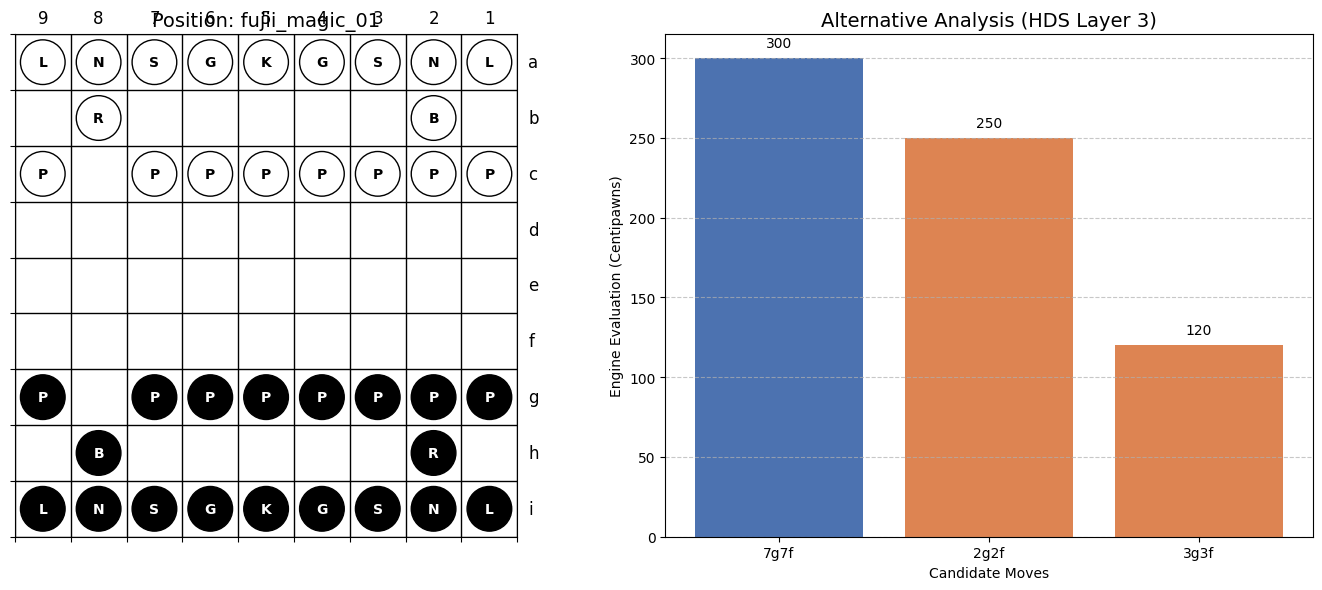


--- Determinism Check (3 runs) ---
OK: HDSログ／要約ともに3回とも完全一致（決定的動作）。


In [1]:
# Shogi Engine Decision Visualization (HDSフレーム・コメント入り完全版)
# - 外部APIなし／決定的（毎回同じ結果）
# - HDS: Objective → Axes → Alternatives → Risk(EVR) → Choice
# - 各候補手ごとに「最善手比パーセンテージ＋日本語コメント」を自動生成

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display

# ------------------------------------------------------------
# 1. 定数・設定
# ------------------------------------------------------------
GAP_SMALL = 80      # < 80cp 差: low_risk_stable
GAP_MEDIUM = 200    # < 200cp 差: balanced（それ以上は high_risk_gambling）
ENGINE_NAME = "DemiGlace-Zero"

# ------------------------------------------------------------
# 2. 入力データ（ここを書き換えれば別局面を説明できる）
#    eval: エンジン評価値（先手有利＝プラス、後手有利＝マイナス想定）
#    policy: 方策確率などがあるなら入れる（なくてもOK）
# ------------------------------------------------------------
sample_position = {
    "position_id": "fujii_magic_01",
    "sfen": "lnsgkgsnl/1r5b1/p1ppppppp/9/9/9/P1PPPPPPP/1B5R1/LNSGKGSNL b - 1",
    "side_to_move": "black",
    "candidate_moves": [
        {
            "move": "7g7f",
            "eval": 300,
            "policy": 0.45,
            "label": "best",
            "desc": "中央の歩を突き出しつつ、玉型の安全性も維持する一手です。"
        },
        {
            "move": "2g2f",
            "eval": 250,
            "policy": 0.30,
            "label": "second",
            "desc": "飛車先の攻めを加速しますが、やや玉型の安定性を犠牲にします。"
        },
        {
            "move": "3g3f",
            "eval": 120,
            "policy": 0.15,
            "label": "third",
            "desc": "角道を通しつつ駒組みを進めますが、全体のバランスはやや劣ります。"
        },
    ],
}

# ------------------------------------------------------------
# 3. 評価値・リスク指標の計算
# ------------------------------------------------------------
def calculate_metrics(candidates):
    df = pd.DataFrame(candidates).copy()

    max_eval = df["eval"].max()
    min_eval = df["eval"].min()
    median_eval = df["eval"].median()

    # 正規化評価値（0〜1）
    df["ev_norm"] = (df["eval"] - min_eval) / (max_eval - min_eval + 1e-9)

    # 最善手との差・中央値との差
    df["gap_to_best"] = max_eval - df["eval"]
    df["gap_to_median"] = median_eval - df["eval"]

    # リスクカテゴリ
    def risk_category(gap):
        if gap < GAP_SMALL:
            return "low_risk_stable"
        elif gap < GAP_MEDIUM:
            return "balanced"
        else:
            return "high_risk_gambling"

    df["risk_category"] = df["gap_to_best"].apply(risk_category)

    # 最善手比パーセンテージ
    df["eval_ratio"] = df["eval"] / (max_eval + 1e-9)

    # 日本語コメント生成
    def make_comment(row):
        ratio_pct = row["eval_ratio"] * 100
        gap = int(row["gap_to_best"])
        cat = row["risk_category"]

        if gap == 0:
            return "候補手の中で最善手です。評価値は基準の100%として扱われます。"

        if cat == "low_risk_stable":
            return (
                f"最善手との差は{gap}点（約{ratio_pct:0.1f}%水準）で、"
                "ほぼ同等の安定した選択肢です。"
            )
        if cat == "balanced":
            return (
                f"最善手との差は{gap}点（約{ratio_pct:0.1f}%水準）で、"
                "十分実戦的ですがやや見劣りします。"
            )
        # high_risk_gambling
        return (
            f"最善手との差は{gap}点（約{ratio_pct:0.1f}%水準）と大きく、"
            "リスクを伴う勝負手寄りの選択です。"
        )

    df["eval_comment"] = df.apply(make_comment, axis=1)
    return df

# ------------------------------------------------------------
# 4. HDSログ（機械的な分解ログ）
# ------------------------------------------------------------
def generate_hds_log(df, position):
    best_row = df.loc[df["eval"].idxmax()]
    log = []

    log.append("=== HDS DECISION LAYER LOG ===")
    log.append(f"Engine: {ENGINE_NAME} | ID: {position['position_id']}")
    log.append("-" * 30)

    # Layer 1: Objective
    log.append("[LAYER 1: OBJECTIVE]")
    log.append(f">> 勝率（評価値）の最大化。現在の最大評価値: {best_row['eval']} 点")
    log.append(">> 副次目的: 一定の安全性を保ちつつ、相手に難しい局面を押し付ける。")
    log.append("")

    # Layer 2: Evaluation Axes
    log.append("[LAYER 2: EVALUATION AXES]")
    log.append("* 駒得・駒の働き（Material / Mobility）")
    log.append("* 玉の安全度（King Safety）")
    log.append("* 主導権・制空権（Initiative / Space）")
    log.append("")

    # Layer 3: Alternatives
    log.append("[LAYER 3: ALTERNATIVES ANALYSIS]")
    for _, row in df.iterrows():
        desc = row.get("desc", "標準的な駒組みの一手です。")
        log.append(
            f">> 手 {row['move']}: 評価値 {row['eval']} 点（正規化 {row['ev_norm']:.2f}）"
        )
        log.append(f"   解説: {desc}")
    log.append("")

    # Layer 4: Risk / EVR
    log.append("[LAYER 4: RISK (EVR) ASSESSMENT]")
    avg_gap = df["gap_to_best"].mean()
    for _, row in df.iterrows():
        log.append(
            f">> {row['move']}: 最善手との差 {int(row['gap_to_best'])} 点 "
            f"-> カテゴリ: {row['risk_category'].upper()}"
        )

    if avg_gap < GAP_SMALL:
        log.append(">> 局面全体: 各候補手の評価が接近しており、安定した状態です。")
    elif avg_gap < GAP_MEDIUM:
        log.append(">> 局面全体: 明確な序列はありますが、複数の実戦的な選択肢があります。")
    else:
        log.append(">> 局面全体: 一手だけが突出しており、事実上その一手を求められる局面です。")
    log.append("")

    # Layer 5: Final Choice
    log.append("[LAYER 5: FINAL CHOICE]")
    log.append(f">> 選択手: {best_row['move']}")
    log.append(
        f">> 採用理由: 評価値 {best_row['eval']} 点で最善、かつリスクカテゴリは "
        f"{best_row['risk_category']} に収まり、全体としてバランスが良いと判断したため。"
    )
    return "\n".join(log)

# ------------------------------------------------------------
# 5. 人間向けサマリー（日本語・上位手の比較）
# ------------------------------------------------------------
def generate_human_summary(df):
    best = df.loc[df["eval"].idxmax()]
    others = df[df["move"] != best["move"]].sort_values("eval", ascending=False)

    lines = []
    lines.append(
        f"この局面で {ENGINE_NAME} は、**{best['move']}** を最有力候補として選択しています。"
    )
    lines.append(
        f"評価値は {best['eval']} 点で候補手群の基準（100%）となる手であり、"
        f"{best.get('desc', '局面全体のバランスを最も良く保つ一手です。')}"
    )

    if not others.empty:
        lines.append("")
        lines.append("他の主要な候補手は次の通りです。")
        for _, row in others.iterrows():
            lines.append(
                f"- **{row['move']}**: 評価値 {row['eval']} 点"
                f"（最善手比 約{row['eval_ratio']*100:0.1f}%）。"
                f" {row['eval_comment']}"
            )
    return "\n".join(lines)

# ------------------------------------------------------------
# 6. 盤面描画（シンプルな9×9将棋盤）
# ------------------------------------------------------------
def plot_shogi_board_simple(sfen, ax):
    board_str = sfen.split()[0]
    rows = board_str.split("/")

    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.grid(True, color="black", linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # ファイル 9〜1
    for i in range(9):
        ax.text(i + 0.5, 9.2, str(9 - i), ha="center", fontsize=12)

    # 段 a〜i 表示
    letters = "abcdefghi"
    for i in range(9):
        ax.text(9.2, 8.5 - i, letters[i], va="center", fontsize=12)

    # 駒の簡易描画（○に文字）
    for r_idx, row_str in enumerate(rows):
        c_idx = 0
        for ch in row_str:
            if ch.isdigit():
                c_idx += int(ch)
            else:
                if ch == "+":
                    continue  # 成駒の+は簡略化
                x = c_idx + 0.5
                y = (8 - r_idx) + 0.5
                is_sente = ch.isupper()
                face_color = "black" if is_sente else "white"
                text_color = "white" if is_sente else "black"

                circle = patches.Circle(
                    (x, y), 0.4, facecolor=face_color, edgecolor="black"
                )
                ax.add_patch(circle)
                ax.text(
                    x,
                    y,
                    ch.upper(),
                    ha="center",
                    va="center",
                    color=text_color,
                    fontweight="bold",
                    fontsize=10,
                )
                c_idx += 1

# ------------------------------------------------------------
# 7. 可視化（盤面＋評価バー）
# ------------------------------------------------------------
def visualize_decision(df, position):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # 盤面
    plot_shogi_board_simple(position["sfen"], ax1)
    ax1.set_title(f"Position: {position['position_id']}", fontsize=14)

    # バーチャート
    colors = ["#4c72b0" if v == df["eval"].max() else "#dd8452" for v in df["eval"]]
    bars = ax2.bar(df["move"], df["eval"], color=colors)
    ax2.set_ylabel("Engine Evaluation (Centipawns)")
    ax2.set_xlabel("Candidate Moves")
    ax2.set_title("Alternative Analysis (HDS Layer 3)", fontsize=14)
    ax2.grid(axis="y", linestyle="--", alpha=0.7)

    for bar in bars:
        h = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            h + 5,
            f"{int(h)}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 8. メイン関数 & 実行
# ------------------------------------------------------------
def explain_position(position):
    df = calculate_metrics(position["candidate_moves"])
    hds_log = generate_hds_log(df, position)
    summary = generate_human_summary(df)
    return df, hds_log, summary

# 実行
df, log_text, summary_text = explain_position(sample_position)

print("\n--- [Data] Candidate Metrics ---")
display(
    df[
        [
            "move",
            "eval",
            "eval_ratio",
            "gap_to_best",
            "risk_category",
            "eval_comment",
        ]
    ]
)

print("\n" + log_text)

print("\n=== EXECUTIVE SUMMARY (Japanese) ===")
print(summary_text)

visualize_decision(df, sample_position)

# ------------------------------------------------------------
# 9. 決定性チェック（3回回して完全一致を確認）
# ------------------------------------------------------------
print("\n--- Determinism Check (3 runs) ---")
logs = []
summaries = []

for _ in range(3):
    df_i, log_i, summary_i = explain_position(sample_position)
    logs.append(log_i)
    summaries.append(summary_i)

assert logs[0] == logs[1] == logs[2], "HDS Logs are not deterministic!"
assert summaries[0] == summaries[1] == summaries[2], "Summaries are not deterministic!"
print("OK: HDSログ／要約ともに3回とも完全一致（決定的動作）。")

# Shogi Engine Decision Visualization (HDSフレーム・コメント入り完全版)

このノートブックは、将棋エンジンの「評価値」と「候補手リスト」から、人間が読める解釈テキストと可視化を自動生成するデモです。

- 入力：
  - ある局面に対する評価値（eval, センチポーン。先手有利＝プラスを想定）
  - 候補手リスト（指し手・方策確率・ラベル・簡易説明など）
- 出力：
  - HDSフレームに沿った意思決定ログ  
    （Objective → Axes → Alternatives → Risk(EVR) → Choice）
  - 最善手比パーセンテージ＋リスクカテゴリ（EVR的評価）
  - 日本語のエグゼクティブサマリー
  - 9×9将棋盤＋候補手評価バーの可視化
  - 決定性チェック（同じ入力に対して毎回同じ結果が出るかの検証）

外部APIや外部エンジン呼び出しは行わず、`sample_position` を書き換えるだけで別局面を説明できる、自己完結・決定的なブラックボックス可視化エンジンとして設計しています。

---

## 1. 定数・設定

コード冒頭では、候補手の「リスク感」をざっくり分類するための閾値を定義しています。

- `GAP_SMALL = 80`  
  最善手との差が 80cp 未満なら `low_risk_stable`。  
  → ほぼ最善手と同等の安定した選択肢とみなします。

- `GAP_MEDIUM = 200`  
  80cp 以上 200cp 未満なら `balanced`。  
  → 実戦的だがやや見劣りする選択肢とみなします。

- それ以上の差は `high_risk_gambling`。  
  → 明確に見劣りする「勝負手寄り」「リスクが高い」選択として扱います。

また、`ENGINE_NAME` で「どのエンジンの出力を可視化しているか」をラベル付けしています（このノートでは `DemiGlace-Zero`）。ここは実際に使うエンジン名に合わせて書き換え可能です。

このセクションは、EVR（Expected Value Range）的なリスク分類をどの基準で行うかを決める部分です。

---

## 2. 入力データ（sample_position）

`sample_position` には、ひとつの局面を表現するための情報をまとめています。

- `position_id`：局面ID（例: `"fujii_magic_01"`）
- `sfen`：局面を表すSFEN文字列
- `side_to_move`：手番（例: `"black"`）
- `candidate_moves`：候補手のリスト  
  各要素は少なくとも以下を持ちます。
  - `move`：指し手（例: `"7g7f"`, `"2g2f"` など）
  - `eval`：その手を選んだ場合の評価値（センチポーン）
  - `policy`：方策確率など（任意）
  - `label`：任意のラベル（例: `"best"`, `"second"`）
  - `desc`：その手の簡単な日本語解説

このディクショナリを書き換えるだけで、任意の局面に対して同じ可視化・説明処理を流すことができます。実際の将棋エンジンと組み合わせる場合は、エンジン側の出力をこの形式にマッピングして利用します。

---

## 3. 評価値・リスク指標の計算（calculate_metrics）

`calculate_metrics` 関数では、候補手ごとに次の指標を計算し、`DataFrame` にまとめています。

- `ev_norm`  
  最小評価値〜最大評価値で正規化した 0〜1 の値です。候補手同士の相対的な位置関係をざっくり見るための指標です。

- `gap_to_best`  
  最善手（最大 `eval`）との差分です。このギャップがリスクカテゴリ判定のベースになります。

- `gap_to_median`  
  候補手全体の中央値との差分です。局面の「ばらけ具合」を見る補助指標です。

- `risk_category`  
  `gap_to_best` を `GAP_SMALL` / `GAP_MEDIUM` で区切って、  
  - `low_risk_stable`  
  - `balanced`  
  - `high_risk_gambling`  
  の3カテゴリに分類します。

- `eval_ratio`  
  `eval / max_eval` として、「最善手評価値を100%としたとき、この手は何％水準か」を表現します。

- `eval_comment`  
  上記指標を用いて、各候補手に対して  
  - 最善手との差（センチポーン）  
  - 最善手比のパーセンテージ  
  - リスクカテゴリ  
  を組み合わせた短い日本語コメントを自動生成します。  
  例えば「ほぼ同等の安定した選択肢」「実戦的だがやや見劣り」「リスクを伴う勝負手寄り」などです。

このセクションは、「単なる数値の差」を、人間が解釈しやすいラベル（安定／バランス／勝負手）に落とし込むための下準備になっています。

---

## 4. HDSログ（機械的な分解ログ、generate_hds_log）

`generate_hds_log` 関数では、HDSフレームに沿ってエンジンの意思決定を5階層に分解したログを生成します。

1. LAYER 1: OBJECTIVE（目的）  
   - 主目的：評価値（≒勝率）の最大化  
   - 副次目的：一定の安全性を保ちつつ、相手に難しい局面を押し付ける  
   → 「この局面でエンジンは何を最優先しているか」を明示します。

2. LAYER 2: EVALUATION AXES（評価軸）  
   - 駒得・駒の働き（Material / Mobility）  
   - 玉の安全度（King Safety）  
   - 主導権・制空権（Initiative / Space）  
   といった、評価の物差しとなる軸を列挙します。

3. LAYER 3: ALTERNATIVES ANALYSIS（候補手分析）  
   候補手ごとに  
   - 手: `move`  
   - 評価値: `eval`  
   - 正規化評価値: `ev_norm`  
   - 人間向け解説: `desc`  
   を並べて機械的な比較ログを出力します。

4. LAYER 4: RISK (EVR) ASSESSMENT（リスク／EVR評価）  
   - 各候補手の `gap_to_best` と `risk_category` を列挙  
   - 平均ギャップなどを用いて、  
     「局面全体が接近戦なのか」「明確に一手だけが突出している局面なのか」をコメントします。  
   例：  
   - 各候補手が接近していれば「安定した状態」  
   - ひとつだけ抜けていれば「事実上その一手を求められる局面」など。

5. LAYER 5: FINAL CHOICE（最終選択）  
   - 最終的に選ばれる最善手（最大 `eval` の手）を明示  
   - 評価値とリスクカテゴリの両面から、「なぜその手を採用したか」を文章で説明します。

このログは、人間が後から読んでも「エンジンの意思決定プロセス」を段階的に追えるように設計された疑似思考ログです。

---

## 5. 人間向けサマリー（generate_human_summary）

`generate_human_summary` 関数は、HDSログよりもさらに読みやすい日本語の要約コメントを生成します。

- 最善手について：
  - どの手を最有力候補としているか  
  - その評価値  
  - `desc` をベースにした自然言語解説

- その他の候補手について：
  - 各手の評価値  
  - 最善手比のパーセンテージ（`eval_ratio * 100`）  
  - `eval_comment` によるリスク／見劣り度の説明  

ノートブック内では

「`=== EXECUTIVE SUMMARY (Japanese) ===`」の下にこのサマリーが表示されます。  
コード実行直後に局面全体の概要をざっと掴むためのレイヤーとして使えます。

---

## 6. 盤面描画（シンプルな9×9将棋盤、plot_shogi_board_simple）

`plot_shogi_board_simple` は、SFEN文字列から駒配置を復元し、簡易的な9×9将棋盤を描画します。

- 9×9のマス目と筋・段のラベル（数字・a〜i）
- 駒は「○＋文字」で簡易表示  
  - 先手側の駒：黒地に白文字  
  - 後手側の駒：白地に黒文字  

このデモでは、あえて表現を簡略化し、

- どこにどの駒がいるか直感的にわかること
- 評価バーとの組み合わせで「局面の雰囲気」を掴みやすくすること

を優先しています。必要に応じて、駒種を漢字にしたり、向きや成り表現を追加する拡張も可能です。

---

## 7. 可視化（盤面＋評価バー、visualize_decision）

`visualize_decision` 関数は、以下の二つを横並びで表示します。

1. 左：`plot_shogi_board_simple` による9×9将棋盤  
2. 右：候補手ごとの評価値バーチャート

評価バーでは、

- 横軸：指し手（`move`）
- 縦軸：評価値（Centipawns）
- 最善手のバーだけ色を変えてハイライト
- 各バーの上に評価値の数値ラベルを表示

という構成にすることで、「どの手が抜けて強いか」「どこまで接戦か」を視覚的に把握できるようにしています。

---

## 8. メイン関数と実行フロー（explain_position）

`explain_position` は、このノートブックの中核となるラッパー関数です。

1. `calculate_metrics` で候補手の各種メトリクスを計算  
2. `generate_hds_log` で HDS 5層構造のログ文字列を生成  
3. `generate_human_summary` で日本語のエグゼクティブサマリーを生成  
4. それらをまとめて返却（`df, log_text, summary_text`）

ノートブックのメイン部分では、

- `df` を `display()` して、候補手ごとの数値指標とコメント一覧を確認  
- `log_text` を表示して、HDSフレームに沿った意思決定ログを確認  
- `summary_text` を表示して、人間向けサマリーを確認  
- `visualize_decision` を呼び出して、盤面と評価バーを描画  

という流れで処理が進みます。

---

## 9. 決定性チェック（Determinism Check）

ノートブック末尾では、同じ `sample_position` に対して `explain_position` を3回実行し、

- HDSログ（`log_text`）
- 日本語サマリー（`summary_text`）

が3回とも完全一致することを `assert` でチェックしています。

これにより、この可視化エンジンが

- ランダム性に依存しない  
- 外部APIにも依存しない  
- 同じ入力に対しては常に同じ出力を返す「決定的な挙動（deterministic）」になっている

ことを確認しています。

---

## 10. 応用と再利用の方向性

- 複数局面を連続して処理し、
  - どの局面で評価が大きく動いたのか
  - どの局面が「一手必至」だったのか  
  を HDSログ付きで時系列に追う分析に拡張する。

- 棋力レベル別（初級・中級・上級）に、用語や説明の深さを切り替えることで、
  対象ユーザーに合わせた説明レイヤーを用意する。

- 将棋以外のゲーム（オセロ・チェスなど）や、
  一般的な最適化アルゴリズムに対しても、
  「候補案＋スコア → HDSログ＋自然言語サマリー」という枠組みをそのまま流用する。

このノートブックは、

「強いエンジンを新しく作ること」ではなく、  
「既存エンジンの決定を、人間にとって意味のある物語と構造として再構成すること」

にフォーカスした、ミニマルなブラックボックス可視化デモです。